# Tutorial - Boolean Circuits

This tutorial covers:
- Low-level circuit construction (using `circkit` framework)
- Using existing circuits from the `wbkit` framework (AES-128)
- Generating pseudorandomness in circuits (`wbkit`), existing and custom
- Applying countermeasures (masking, shuffling) to circuits (`wbkit`)

## Low-level circuit construction (`circkit`)

### Basic Boolean circuits

In [1]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit

In [2]:
C = BooleanCircuit(name="maj3_and_mux")

x = C.add_input("x")
y = C.add_input("y")
z = C.add_input("z")

maj = x & y ^ x & z ^ y & z
mux = x & y ^ ~x & z
C.add_output(maj)
C.add_output(mux)

C.print_stats()

maj3_and_mux(OptBooleanCircuit): 
   |     3 inputs,    2 outputs,     11 nodes
   | AND:4 (36.36%), INPUT:3 (27.27%), XOR:3 (27.27%), NOT:1 (9.09%)


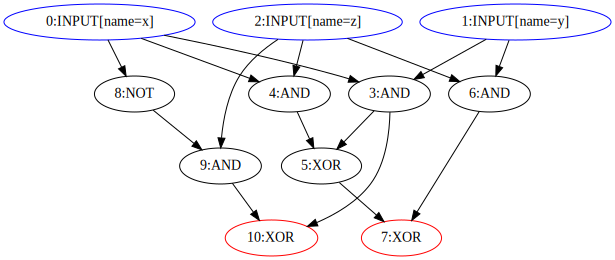

In [3]:
C.digraph()

In [4]:
C.evaluate([0, 0, 1])

[0, 1]

In [5]:
C.evaluate([1, 0, 1])

[1, 0]

### Vectorial Helpers

`Array` wraps a list of any objects, adds useful operations (such as rotations), and delegates various operations to the elements (which could be e.g. circuit nodes or integers or anything else (compatible)).

In [26]:
from circkit.array import Array

In [21]:
Array([0, 0, 1, 1]) ^ Array([0, 1, 0, 1])

[0, 1, 1, 0]

In [22]:
Array([0, 0, 1, 1]) & Array([0, 1, 0, 1])

[0, 0, 0, 1]

In [23]:
Array([0, 0, 0, 0, 1]).rol(2)

[0, 0, 1, 0, 0]

Now, we will create a circuit for the (simplified) Simon block cipher. This illustrates the usage of `Array`.

In [35]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from random import randrange

N_ROUNDS = 32

C = BooleanCircuit("Simon32")

pt = Array(C.add_inputs(32, "pt%d"))
keys = [
    Array([randrange(2) for _ in range(16)])
    for _ in range(N_ROUNDS)
]  

l, r = pt.chunks(num=2)
for round in range(32):
    r ^= (l.rol(1) & l.rol(8)) ^ l.rol(2) ^ keys[round]
    l, r = r, l

ct = Array.concat(l, r)

C.add_output(ct)

print(C.evaluate([0] * 32))

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]


## Existing circuits from the `wbkit` framework (AES-128)

`binteger.Bin` is an utility module to convert and manipulate bitstrings, bytes, ints (words).

In [28]:
from binteger import Bin

In [31]:
Bin(127, 10)

Bin(0b0001111111, n=10)

In [33]:
Bin(0x4141, 16).bytes

b'AA'

In [37]:
Bin(b"AA").tuple

(0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1)

We will use `Bin` to convert `bytes` constants (plaintexts/ciphertexts, master keys) into bit sequences and vice versa.

In the following, we use an existing AES circuit generator from `wbkit`, to create an AES circuit with a **hardcoded key**.

In [46]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from wbkit.ciphers.aes import BitAES
from wbkit.ciphers.aes.aes import encrypt

key = b"abcdefghABCDEFGH"
key_bits = Bin(key).tuple

C = BooleanCircuit(name="AES")

pt = C.add_inputs(128)

ct, k10 = BitAES(pt, key_bits, rounds=10)

C.add_output(ct)

C.in_place_remove_unused_nodes()

C.print_stats()

AES(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  31273 nodes
   | XOR:19284 (61.66%), AND:6240 (19.95%), NOT:5621 (17.97%), INPUT:128 (0.41%)


In [47]:
plaintext = b"0123456789abcdef"
ciphertext_bits = C.evaluate(Bin(plaintext).tuple)
ciphertext = Bin(ciphertext_bits).bytes
ciphertext.hex()

'54b03463c5b5a1d45efb4e91637ba51f'

In [49]:
from Crypto.Cipher import AES

AES.new(key).encrypt(plaintext).hex()

'54b03463c5b5a1d45efb4e91637ba51f'

We can also let key be an extra input.

In [51]:
C = BooleanCircuit(name="AES")

pt = C.add_inputs(128)
key = C.add_inputs(128)

ct, k10 = BitAES(pt, key, rounds=10)

C.add_output(ct)

C.in_place_remove_unused_nodes()

C.print_stats()

AES(OptBooleanCircuit): 
   |   256 inputs,  128 outputs,  39893 nodes
   | XOR:25452 (63.80%), AND:7800 (19.55%), NOT:6385 (16.01%), INPUT:256 (0.64%)


In [54]:
test_plaintext = b"0123456789abcdef"
test_key = b"abcdefghABCDEFGH"

test_ciphertext = C.evaluate(Bin(test_plaintext + test_key).tuple)
test_ciphertext = Bin(test_ciphertext).bytes
test_ciphertext.hex()

'54b03463c5b5a1d45efb4e91637ba51f'

In [55]:
test_plaintext = b"0123456789abcdef"
test_key = b"abcdefghABCDEFGh"

test_ciphertext = C.evaluate(Bin(test_plaintext + test_key).tuple)
test_ciphertext = Bin(test_ciphertext).bytes
test_ciphertext.hex()

'4c78f17f5a638a244d6d7409fdc037e8'